# MediaPipe Hand Tracking Inference Workflow

In [67]:
import os
import csv
import glob

import cv2
import tensorflow as tf
import numpy as np
np.seterr(over='ignore')

import matplotlib.pyplot as plt
%matplotlib inline

# Palm Detector

## Example Label

[<div><img style="margin-left=0; !important" src="https://lh6.googleusercontent.com/eiAXkFzur-YRrtIYHpV0YTD2SZR_TAojq7K4GqBR9kzR5elW8T0JlAW6EKx2qGPwrW3W10Y1rWATgErf_xd4NlVzXSgT8C7y9cPtDRy8EQ-rc2R6Lhjp65ie1_usaE8ss05fJHA-" width="250"/></div>](image.png)

## Load Model and Pre-defined Anchors

In [68]:
# Load Palm Detection Model
DETECTION_THRESHOLD = 0.8
PALM_DETECTOR_PATH = os.path.join('models', 'palm_detection_without_custom_op.tflite')
ANCHOR_PATH = os.path.join('models', 'anchors.csv')
palm_detector = tf.lite.Interpreter(model_path=PALM_DETECTOR_PATH)
palm_detector.allocate_tensors()
_, INPUT_HEIGHT, INPUT_WIDTH, _ = palm_detector.get_input_details()[0]['shape']

with open(ANCHOR_PATH, "r") as csv_f:
    ANCHORS = np.r_[[x for x in csv.reader(csv_f, quoting=csv.QUOTE_NONNUMERIC)]]

print("input width: %s\ninput height: %s" % (INPUT_WIDTH, INPUT_HEIGHT))
input_details = palm_detector.get_input_details()
output_details = palm_detector.get_output_details()

input width: 256
input height: 256


## Preprocess Input Image

In [69]:
def preprocess(bgr_image, w, h):
    # convert to rgb
    rgb_image = bgr_image[:, :, ::-1]
    # pad to square and resize
    shape = np.r_[rgb_image.shape]
    padding = (shape.max() - shape[:2]).astype('uint32') // 2
    rgb_image = np.pad(rgb_image, ((padding[0], padding[0]), (padding[1], padding[1]), (0, 0)), mode='constant')
    rgb_image = cv2.resize(rgb_image, (w, h))
    rgb_image = np.ascontiguousarray(rgb_image)
    # normalize
    rgb_image = np.ascontiguousarray(2 * ((rgb_image / 255) - 0.5).astype('float32'))
    # reshape as input shape
    rgb_image = rgb_image[tf.newaxis, ...]
    return rgb_image, padding

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


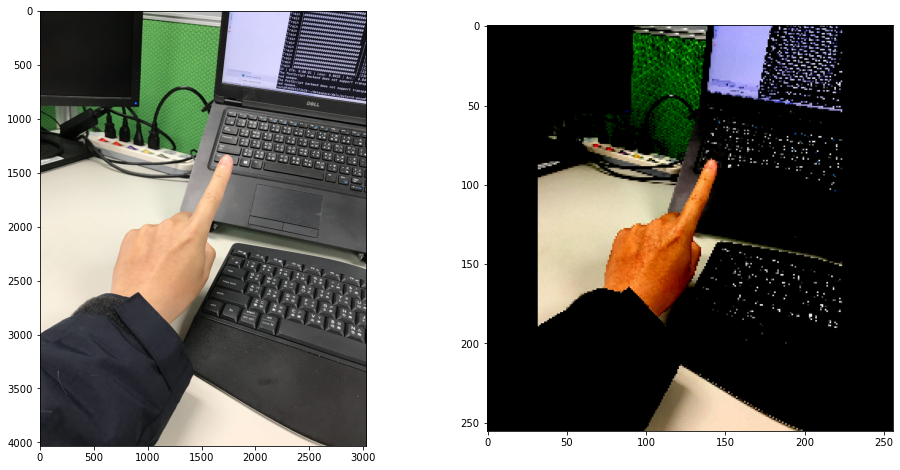

In [70]:
# read a image
original_image = cv2.imread(np.random.choice(glob.glob(os.path.join('test_image', '*g'))))
input_image, padding = preprocess(original_image.copy(), INPUT_WIDTH, INPUT_HEIGHT)
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(original_image[:,:,::-1])
plt.subplot(122)
plt.imshow(input_image[0])
plt.show()

## Inference

In [71]:
# inference
palm_detector.set_tensor(input_details[0]['index'], input_image)
palm_detector.invoke()
output_reg = palm_detector.get_tensor(output_details[0]['index'])[0]
output_clf = palm_detector.get_tensor(output_details[1]['index'])[0, :, 0]

## Convert Predictions to Bounding Boxes

**output_reg shape = (number of anchors, number of predictions)**

- number of anchors = 2944

- number of predictions = 18 

    - 0 to 4 are bounding box offset, width and height: dx, dy, w ,h

    - 4 to 18 are 7 hand keypoint x and y coordinates: x1, y1, x2, y2, ..., x7, y7

**output_clf shape = (number of anchors, 1)**

### classification score should be normalized by sigmoid function

In [72]:
def sigmoid(values):
    return 1/(1+np.exp(-values))

In [73]:
scores = sigmoid(output_clf)

### filter predictions with scores

In [74]:
output_reg = output_reg[scores>DETECTION_THRESHOLD]
output_clf = output_clf[scores>DETECTION_THRESHOLD]
candidate_anchors = ANCHORS[scores>DETECTION_THRESHOLD]

In [75]:
if output_reg.shape[0] == 0:
    print("No hands found")

### move bounding boxes with anchors

In [76]:
moved_output_reg = output_reg.copy()
moved_output_reg[:, :2] = moved_output_reg[:, :2] + candidate_anchors[:, :2] * 256

### apply NMS for Boxes

In [77]:
def non_max_suppression_fast(boxes, probabilities=None, overlap_threshold=0.3):
    """
    Algorithm to filter bounding box proposals by removing the ones with a too low confidence score
    and with too much overlap.
    Source: https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    :param boxes: List of proposed bounding boxes
    :param overlap_threshold: the maximum overlap that is allowed
    :return: filtered boxes
    """
    # if there are no boxes, return an empty list
    if boxes.shape[1] == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0] - (boxes[:, 2] / [2])  # center x - width/2
    y1 = boxes[:, 1] - (boxes[:, 3] / [2])  # center y - height/2
    x2 = boxes[:, 0] + (boxes[:, 2] / [2])  # center x + width/2
    y2 = boxes[:, 1] + (boxes[:, 3] / [2])  # center y + height/2

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = boxes[:, 2] * boxes[:, 3]  # width * height
    idxs = y2


    # if probabilities are provided, sort on them instead
    if probabilities is not None:
        idxs = probabilities

    # sort the indexes
    idxs = np.argsort(idxs)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > overlap_threshold)[0])))
    # return only the bounding boxes that were picked
    return pick

In [78]:
box_ids = non_max_suppression_fast(moved_output_reg[:, :4], output_clf)

### extract bounding boxes and 7 key points

In [79]:
center_wo_offst = candidate_anchors[box_ids,:2] * 256
bboxes = moved_output_reg[box_ids, :4].astype('int')
keypoints_set = output_reg[box_ids,4:].reshape(-1, 7, 2)
for i in range(len(keypoints_set)):
    keypoints_set[i] = keypoints_set[i] + center_wo_offst[i]

In [80]:
result_image = input_image.copy()[0]
# box
for bbox in bboxes:
    tmp_bbox = bbox
    cx, cy, w, h = bbox
    x1, y1, x2, y2 = (cx-w//2, cy-h//2, cx+w//2, cy+h//2)
    result_image = cv2.rectangle(result_image, (x1,y1), (x2,y2), (0,255,0), 1)
# keypoint
for keypoints in keypoints_set:
    for keypoint in keypoints:
        tmp_keypoint = keypoint.copy()
        cv2.circle(result_image, (int(tmp_keypoint[0]), int(tmp_keypoint[1])), 2, (255, 255, 0), 2)

resize_result_image = np.pad(original_image[:,:,::-1], 
                             ((padding[0], padding[0]), (padding[1], padding[1]), (0, 0)), mode='constant').copy()
# box
for bbox in bboxes:
    tmp_bbox = bbox
    cx, cy, w, h = bbox
    cy = cy * resize_result_image.shape[0] // INPUT_HEIGHT
    cx = cx * resize_result_image.shape[1] // INPUT_WIDTH
    h = h * resize_result_image.shape[0] // INPUT_HEIGHT
    w = w * resize_result_image.shape[1] // INPUT_WIDTH
    x1, y1, x2, y2 = (cx-w//2, cy-h//2, cx+w//2, cy+h//2)    
    resize_result_image = cv2.rectangle(resize_result_image, (x1,y1), (x2,y2), (0,255,0), 3)

# keypoint
for keypoints in keypoints_set:
    for keypoint in keypoints:
        tmp_keypoint = keypoint.copy()
        tmp_keypoint[0] = tmp_keypoint[0] * resize_result_image.shape[1] // INPUT_WIDTH
        tmp_keypoint[1] = tmp_keypoint[1] * resize_result_image.shape[0] // INPUT_HEIGHT
        cv2.circle(resize_result_image, (int(tmp_keypoint[0]), int(tmp_keypoint[1])), 3, (255, 255, 0), 3)
        
original_result_image = original_image[:,:,::-1].copy()
# box
for bbox in bboxes:
    tmp_bbox = bbox
    cx, cy, w, h = bbox
    cy = cy * resize_result_image.shape[0] // INPUT_HEIGHT
    cx = cx * resize_result_image.shape[1] // INPUT_WIDTH
    h_resize = h * resize_result_image.shape[0] // INPUT_HEIGHT
    w_resize = w * resize_result_image.shape[1] // INPUT_WIDTH
    cx -= padding[1]
    cy -= padding[0]
    x1, y1, x2, y2 = (cx-w_resize//2, cy-h_resize//2, cx+w_resize//2, cy+h_resize//2)
    original_result_image = cv2.rectangle(original_result_image, (x1,y1), (x2,y2), (0,255,0), 3)

# keypoint
for keypoints in keypoints_set:
    for keypoint in keypoints:
        tmp_keypoint = keypoint.copy()
        tmp_keypoint[0] = tmp_keypoint[0] * resize_result_image.shape[1] // INPUT_WIDTH
        tmp_keypoint[1] = tmp_keypoint[1] * resize_result_image.shape[0] // INPUT_HEIGHT
        tmp_keypoint[0] -= padding[1]
        tmp_keypoint[1] -= padding[0]
        cv2.circle(original_result_image, (int(tmp_keypoint[0]), int(tmp_keypoint[1])), 3, (255, 255, 0), 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


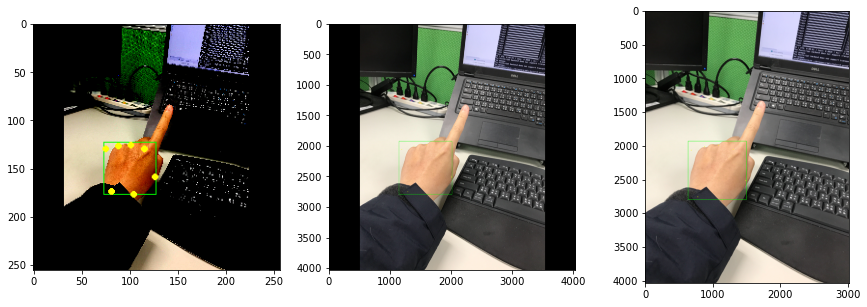

In [81]:
# show
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(result_image)
plt.subplot(132)
plt.imshow(resize_result_image)
plt.subplot(133)
plt.imshow(original_result_image)
plt.show()

## Convert Palm Detector Output to Landmark Model Input

In [82]:
def get_triangle(kp0, kp2, dist=1):
    """get a triangle used to calculate Affine transformation matrix"""

    dir_v = kp2 - kp0
    dir_v /= np.linalg.norm(dir_v)

    dir_v_r = dir_v @ np.r_[[[0,1],[-1,0]]].T
    return np.float32([kp2, 
                       kp2 + dir_v*dist, 
                       kp2 + dir_v_r*dist])

In [83]:
def triangle_to_bbox(source):
    # plain old vector arithmetics
    bbox = np.c_[
        [source[2] - source[0] + source[1]],
        [source[1] + source[0] - source[2]],
        [3 * source[0] - source[1] - source[2]],
        [source[2] - source[1] + source[0]],
    ].reshape(-1,2)
    return bbox

In [84]:
side = max(w,h) * 1.3
source = get_triangle(keypoints[0], keypoints[2], side)
source -= (keypoints[0] - keypoints[2]) * 0.2

In [85]:
target_triangle = np.float32([[128, 128],
                              [128,   0],
                              [  0, 128]])

In [86]:
shape = np.r_[original_image.shape]
padding = (shape.max() - shape[:2]).astype('uint32') // 2
img_pad = np.pad(original_image, ((padding[0], padding[0]), (padding[1], padding[1]), (0, 0)), mode='constant')

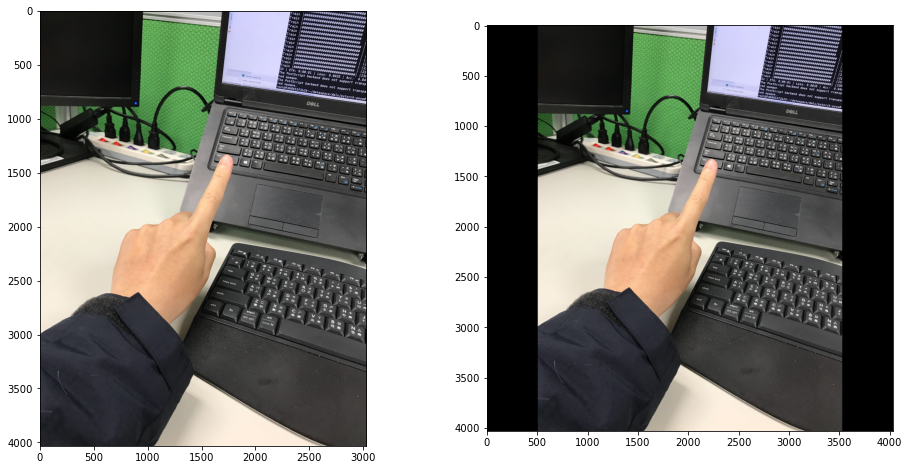

In [87]:
# read a image
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(original_image[:,:,::-1])
plt.subplot(122)
plt.imshow(img_pad[:,:,::-1])
plt.show()

In [88]:
img_pad_show = img_pad.copy()
# box
for bbox in bboxes:
    tmp_bbox = bbox
    cx, cy, w, h = bbox
    cy = cy * img_pad_show.shape[0] // INPUT_HEIGHT
    cx = cx * img_pad_show.shape[1] // INPUT_WIDTH
    h = h * img_pad_show.shape[0] // INPUT_HEIGHT
    w = w * img_pad_show.shape[1] // INPUT_WIDTH
    x1, y1, x2, y2 = (cx-w//2, cy-h//2, cx+w//2, cy+h//2)    
    img_pad_show = cv2.rectangle(img_pad_show, (x1,y1), (x2,y2), (0,255,0), 2)

# keypoint
for keypoints in keypoints_set:
    for keypoint in keypoints:
        tmp_keypoint = keypoint.copy()
        tmp_keypoint[0] = tmp_keypoint[0] * img_pad_show.shape[1] // INPUT_WIDTH
        tmp_keypoint[1] = tmp_keypoint[1] * img_pad_show.shape[0] // INPUT_HEIGHT
        cv2.circle(img_pad_show, (int(tmp_keypoint[0]), int(tmp_keypoint[1])), 4, (255, 0, 0), 4)

cv2.line(img_pad_show, 
         tuple((keypoints[0] * img_pad_show.shape[1] // INPUT_WIDTH).astype('int')), 
         tuple((keypoints[2] * img_pad_show.shape[0] // INPUT_WIDTH).astype('int')),
         (0, 0, 255), 3)

Mtr = cv2.getAffineTransform(source * max(original_image.shape) / 256, target_triangle)

img_landmark = cv2.warpAffine(img_pad, Mtr, (256,256))

In [89]:
new_bbox = triangle_to_bbox(source* max(original_image.shape) / 256)

In [90]:
for i in [(0,1), (1,2), (2,3), (3,0)]:
    cv2.line(img_pad_show, tuple(new_bbox[i[0]].astype('int')), tuple(new_bbox[i[1]].astype('int')), (0, 0, 255), 3)

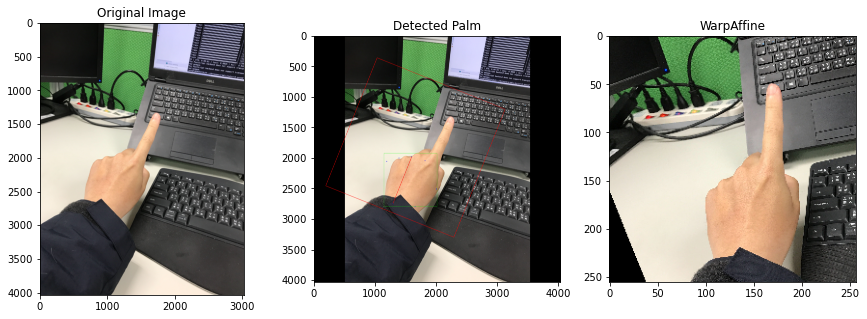

In [91]:
# read a image
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Original Image")
plt.imshow(original_image[:,:,::-1])

plt.subplot(132)
plt.title("Detected Palm")
plt.imshow(img_pad_show[:,:,::-1])

plt.subplot(133)
plt.title("WarpAffine")
plt.imshow(img_landmark[:,:,::-1])

plt.show()

# Hand Landmaek Model

## Load Model

In [92]:
# Load Palm Detection Model
HAND_LANDMARK_PATH = os.path.join('models', 'hand_landmark.tflite')
hand_landmaek_model = tf.lite.Interpreter(model_path=HAND_LANDMARK_PATH)
hand_landmaek_model.allocate_tensors()
_, INPUT_HEIGHT, INPUT_WIDTH, _ = hand_landmaek_model.get_input_details()[0]['shape']
# in_idx_joint = hand_landmaek_model.get_input_details()[0]['index']
# out_idx_joint = hand_landmaek_model.get_output_details()[0]['index']
# input_details[0]['index']
print("input width: %s\ninput height: %s" % (INPUT_WIDTH, INPUT_HEIGHT))
input_details = hand_landmaek_model.get_input_details()
output_details = hand_landmaek_model.get_output_details()

input width: 256
input height: 256


## Inference

In [93]:
input_image = np.ascontiguousarray(2 * ((img_landmark[:,:,::-1] / 255) - 0.5).astype('float32'))

In [94]:
hand_landmaek_model.set_tensor(input_details[0]['index'], input_image.reshape(1,256,256,3))
hand_landmaek_model.invoke()
joints = hand_landmaek_model.get_tensor(output_details[0]['index'])
joints = joints.reshape(-1,2)

## See Result

In [95]:
img_landmark_show = img_landmark.copy()
# keypoint
for keypoint in joints:
    tmp_keypoint = keypoint.copy()
    cv2.circle(img_landmark_show, (int(tmp_keypoint[0]), int(tmp_keypoint[1])), 2, (255, 0, 0), 2)

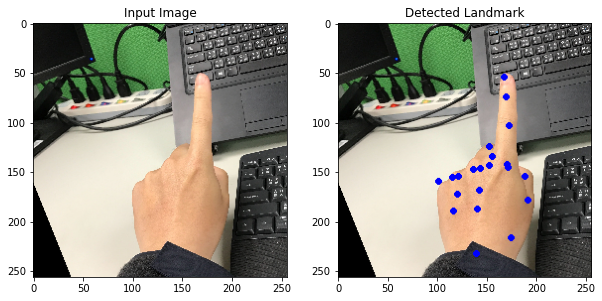

In [96]:
# read a image
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title("Input Image")
plt.imshow(img_landmark[:,:,::-1])

plt.subplot(122)
plt.title("Detected Landmark")
plt.imshow(img_landmark_show[:,:,::-1])

plt.show()

## Convert Key Points Back to Original Image

In [97]:
Mtr = np.pad(Mtr.T, ((0,0),(0,1)), constant_values=1, mode='constant').T
Mtr[2,:2] = 0
MtrInv = np.linalg.inv(Mtr)

# projecting keypoints back into original image coordinate space
kp_orig = (np.pad(joints, ((0,0),(0,1)), constant_values=1, mode='constant') @ MtrInv.T)[:,:2]
kp_orig -= padding[::-1]

In [98]:
final_result_image = original_image.copy()
# keypoint
# for keypoint in kp_orig:
#     tmp_keypoint = keypoint.copy()
#     cv2.circle(final_result_image, (int(tmp_keypoint[0]), int(tmp_keypoint[1])), 4, (255, 0, 0), 4)

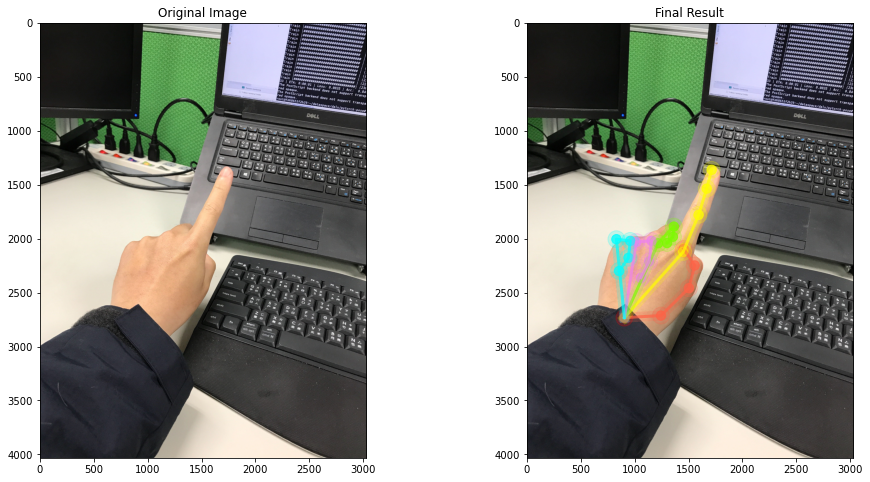

In [99]:
# read a image
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.title("Original Image")
plt.imshow(original_image[:,:,::-1])

plt.subplot(122)
plt.title("Final Result")
colors = ['tomato', 'yellow', 'lawngreen', 'violet', 'aqua']
a = ['r']
[a.extend([color]*4) for color in colors]
colors = a

xs, ys = [p[0] for p in kp_orig], [p[1] for p in kp_orig]
plt.scatter(xs, ys, c=colors, s=87, alpha=0.7)
plt.scatter(xs, ys, c=colors, s=287, alpha=0.2)
# for i in range(21):
#     plt.text(xs[i], ys[i], str(i), fontsize=12)
for i in range(1, 18, 4):
    temp_x = [xs[0]] + [xs[i+j] for j in range(4)]
    temp_y = [ys[0]] + [ys[i+j] for j in range(4)]
    plt.plot(temp_x, temp_y, c=a[i], linewidth=3, alpha=0.7)
    plt.plot(temp_x, temp_y, c=a[i], linewidth=10, alpha=0.2)
plt.imshow(final_result_image[:,:,::-1])


plt.show()